# Homework 3: Mining Data Streams

The implemented graph processing algorithm follwed the wor in the paper by "L. De Stefani, A. Epasto, M. Riondato, and E. Upfal, TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size, KDD'16".

#### (A) Implementation

The implemeation (BASE and IMPROVED) algorithm is based on the following two steps:

+	First, implement the reservoir sampling:
  The TRIEST-BASE algorithm estimates the number of triangles in a dynamic graph stream with fixed memory size. The key idea is to maintain a reservoir of edges using reservoir sampling to provide unbiased estimates of the triangle count.

+ Second, the TRIEST-IMPR algorithm improves upon TRIEST-BASE by incorporating a new mechanism to handle edge deletions efficiently. It maintains a sample of the graph state and uses a decay factor to adjust the contribution of older edges. The implementation is more involved than TRIEST-BASE.

#### (B) Evaluation:
+ We used the Directed Epinions social network data streams
(directed graph).

  + Members of the site can decide whether to ''trust'' each other.
  
  + All the trust relationships interact and form the Web of Trust which is then combined with review ratings to determine which reviews are shown to the user.

  + Number of metrics are provided such as: the datasect contains [75879] nodes, the edges number is [508837] Aveage cultersing coefficent is[0.1378] and the triangles number is [1624481].

+ The conducted evalaution is focused on comparing the estiamtion made by the implemeted Triest Base and Improved algorithm in A t real rsults present your test results provided in the dataset (e.g. number of triangles).



# Intialization

In [ ]:
# Import necessary libraries
import pandas as pd
from itertools import chain, combinations
import os
import glob
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import math

+ Load Data

In [ ]:
# Combine CoLab with my google drive (file path)

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/DataMining Course 2023/Homework 3"

  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/Colab Notebooks/DataMining Course 2023/Homework 3  exists.

Colab: Changing directory to  /content/gdrive/My Drive/Colab Notebooks/DataMining Course 2023/Homework 3
/content/gdrive/My Drive/Colab Notebooks/DataMining Course 2023/Homework 3


In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Construct the file path
file_path = os.path.join(current_directory, 'soc-Epinions1.txt')
print (file_path)

/content/gdrive/My Drive/Colab Notebooks/DataMining Course 2023/Homework 3/soc-Epinions1.txt


# Read dataset and check structure

+ Store Edges stream as list of sets

In [ ]:
edges_list=[]
with open(file_path, 'r') as file:
    # Skip the first four lines as they contain metadata
    for _ in range(4):
        next(file)

    # Parse lines into sets
    for line in file:
        data = line.strip().split('\t')
        from_node = int(data[0])
        to_node = int(data[1])

        # Add edge as a set to the list
        edges_list.append({from_node, to_node})

# Define a class called TriestBase
Introducing the TriestBase class, this code implements a fundamental version of the TRIÈST (TRIangle Estimation in STreams) algorithm. TRIÈST is designed for estimating the number of triangles in a streaming graph, where edges are introduced one at a time. The algorithm maintains a sample of edges to make estimations, updating this sample set as new edges arrive. It utilizes reservoir sampling to sustain a random edge sample from the graph and adjusts triangle counts based on the sampled edges.

The implemenation can be described as follows:
  1. **EdgeSample Class:**
    The `sample_edge` class is used to maintain a sample of edges from the graph stream (it can be considered as means to ccreate a Subgraph from the graph Stream).
      + **The __init__ method :** intilization of use parameters
      + **The add_edge method:** This method add smaple to the sampled edges set (our subgrap). Other methods in Triest Algoritm Glass determines whether an incoming edge should be sampled based on the reservoir size (M).
      + **The Random Edge Removal method:** When an edge is sampled for removal, the `remove_random_edge` method in the EdgeSample class is invoked to eliminate a random edge from the sample. The invoke of this method (deleteion of an edge from the sample set) will invoke update/changes in our local and global counters.
      + **The get_intersection_neighborhood method**: This method is used to storing the neighbors of each node and find common neigbours for any pair of nodes u and v. To preserve the memory constraints, we make sure to remove nodes from the adjacency list if their degree is 0. At any point in time, we have at maximum M edges present in the adjacency list given the properties of reservoir sampling. The output is importatin for the tringle estimation.
    
  2. **TriestBase class:** This class implements the Triest Base algorithm for estimating global and local triangle counts in a graph stream.
      + **The __init__ method:** initializes the algorithm with a reservoir size (reservoir_size), an optional edge_sample (an instance of the EdgeSample class, which defaults to a new EdgeSample instance), and other counters.
      + **sample_edge:**  method decides whether to keep an incoming edge in the sample based on reservoir sampling logic. It updates triangle counts accordingly.This  simulates a biased coin flip, this is a form of filtering where the new edge has a chance to replace an existing edge in the sample.
        + For the first 'M' elements, the probability of being selected is 1, which is M/M.
        + For the (M+1)-th element, the probability of being selected is M/(M+1), and so on.
        + For any i-th element (where i > M), the probability of being selected is M/i.
        
    + **update_triangle_counts:** This method adjusts global and local triangle counts based on the operation (addition or removal) of an edge. It takes into account the common neighborhood of the nodes in the edge. This method is called after each insertion and removal of an edge happeend in the sampled edges set (subgraph).
    + **Processing Edges:** This method takes a list of edges, processes them one by one, and updates the sample and triangle counts accordingly.
    + **return_triangle_counts:** This method provides the estimated global and local triangle counts. The estimates are scaled using a factor calculated based on the total number of edges processed and the reservoir size.




1624481

In [10]:
import random

class EdgeSample:
    def __init__(self):
        # Set to store edges we've seen
        self.edges = set()

    def add_edge(self, edge):
        # Convert the set 'edge' to a tuple before adding to the set
        self.edges.add(tuple(edge))

    def remove_random_edge(self):
        # Remove and return a random edge if we have any
        return self.edges.pop() if self.edges else None

    def get_intersection_neighborhood(self, edge):
        # Get the common nodes from an edge
        return set(edge)

class TriestBase:
    def __init__(self, reservoir_size, edge_sample=None):
        # Initialize the TriestBase algorithm
        self.reservoir_size = reservoir_size
        self.sample = edge_sample or EdgeSample()
        self.global_triangle_count = 0
        self.local_triangle_count = {}
        self.total_edges_seen = 0

    def sample_edge(self, edge):
        # Check if we should keep the edge in our sample

        self.total_edges_seen += 1

        if self.total_edges_seen <= self.reservoir_size:
            # If our sample isn't full, keep the edge with probability 1
            return True

        # Calculate the probability of keeping the new edge
        probability = self.reservoir_size / self.total_edges_seen

        # Perform a biased coin flip to decide whether to keep the new edge
        if random.random() <= probability:
            # Keep the edge
            return True

        # If the new edge is not selected, replace a random existing edge
        removed_edge = self.sample.remove_random_edge()
        if removed_edge:
            # If we removed an edge, update the triangle counts
            self.update_triangle_counts(removed_edge, '-')

        return False

    def update_triangle_counts(self, edge, operation):
        # Update our triangle counts based on the edge and operation

        common_neighbors = self.sample.get_intersection_neighborhood(edge)

        for node in common_neighbors:
            if operation == '+':
                # Increment counts for addition
                self.local_triangle_count[node] = self.local_triangle_count.get(node, 0) + 1
            elif operation == '-':
                # Decrement counts for removal
                self.local_triangle_count[node] -= 1
                if self.local_triangle_count[node] == 0:
                    del self.local_triangle_count[node]

        if operation == '+':
            # Increment global count for addition
            self.global_triangle_count += 1
        elif operation == '-':
            # Decrement global count for removal
            self.global_triangle_count -= 1

    def process_edges(self, edges):
        # Process a list of edges (sets) to update our triangle counts

        for edge in edges:
            edge = tuple(edge)  # Convert set to tuple for consistency
            if self.sample_edge(edge):
                # If we keep the edge, add it to our sample and update triangle counts
                self.sample.add_edge(edge)
                self.update_triangle_counts(edge, '+')

    def return_triangle_counts(self):
        # Return our estimated global and local triangle counts

        estimate = max(1, (self.total_edges_seen * (self.total_edges_seen - 1) * (self.total_edges_seen - 2)) /
                       (self.reservoir_size * (self.reservoir_size - 1) * (self.reservoir_size - 2)))
        global_estimate = int(estimate * self.global_triangle_count)
        local_estimate = {key: int(value * estimate) for key, value in self.local_triangle_count.items()}
        return {'global': global_estimate, 'local': local_estimate}

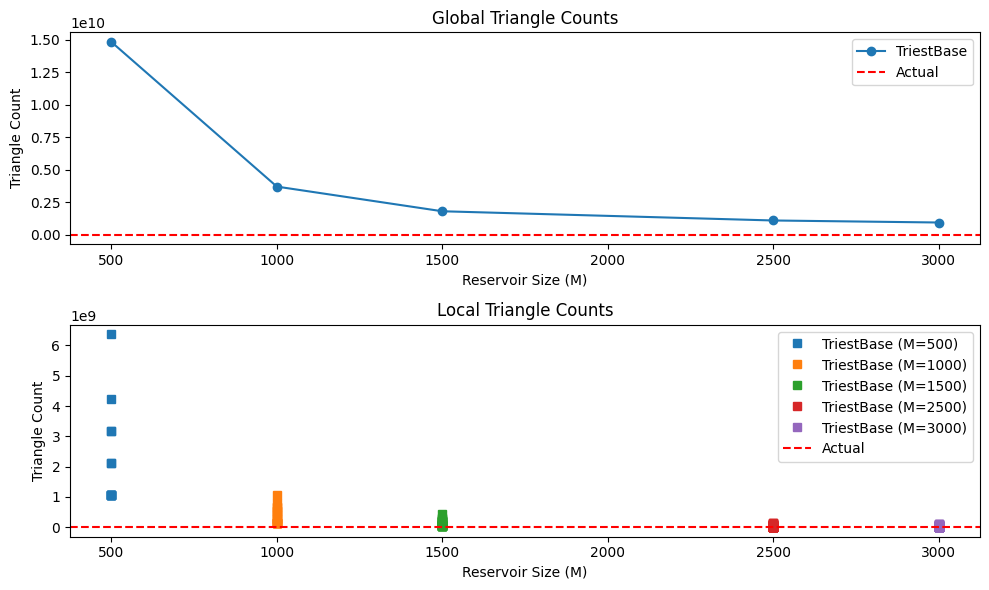

In [11]:
# Actual triangle count (from give data_set info)
actual_triangle_count = 1624481
reservoir_sizes = [500, 1000, 1500, 2500, 3000]
results_base = {'global': {}, 'local': {}}

for M in reservoir_sizes:
    edge_sample_base = EdgeSample()
    # Create an instance of TriestBase
    triest = TriestBase(M, edge_sample_base)

    # Process the edges
    triest.process_edges(edges_list)

    # Get the estimated triangle counts
    counters = triest.return_triangle_counts()
    counters_base = counters
    results_base['global'][M] = counters_base['global']
    results_base['local'][M] = counters_base['local']

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot global triangle count estimates for TriestBase and TriestImpr
plt.subplot(2, 1, 1)
plt.plot(reservoir_sizes, [results_base['global'][M] for M in reservoir_sizes], marker='o', label='TriestBase')
plt.axhline(y=actual_triangle_count, color='r', linestyle='--', label='Actual')
plt.title('Global Triangle Counts')
plt.xlabel('Reservoir Size (M)')
plt.ylabel('Triangle Count')
plt.legend()

# Plot local triangle count estimates for TriestImpr
plt.subplot(2, 1, 2)
for M in reservoir_sizes:
    plt.plot([M]*len(results_base['local'][M]), results_base['local'][M].values(), 's', label=f'TriestBase (M={M})')

plt.axhline(y=actual_triangle_count, color='r', linestyle='--', label='Actual')
plt.title('Local Triangle Counts')
plt.xlabel('Reservoir Size (M)')
plt.ylabel('Triangle Count')
plt.legend()

plt.tight_layout()
plt.show()


# Define a class called TriestImpr

In this code, the TriestImpr class extends the TriestBase class, inheriting its methods and attributes. The apply_decay method is called after processing each edge to simulate the decay mechanism for edge deletion. This modification allows the algorithm to adapt to changes in the graph by gradually removing edges from the sample set based on the specified decay_factor.

This enhancement allows the algorithm to adapt to changes in the graph over time, giving less importance to older edges through the decay factor. The decay factor can introduce a bias towards newer edges, potentially causing the algorithm to underrepresent the importance of long-standing edges. This bias needs to be considered in the context of the specific application or characteristics of the graph.

+ When the decay factor is high, the algorithm adapts more quickly to changes in the graph. Older edges have a higher probability of being removed, making the sampled graph more reflective of recent edges.
+ A lower decay factor makes the algorithm less responsive to changes, providing more stability in the sampled graph by retaining older edges for a more extended period.
+ More emphasis on recent edges means the algorithm is better suited for dynamic graphs where the importance of edges evolves over time. However, it might be more sensitive to fluctuations and may have a higher variance in triangle count estimates.

+ The algorithm becomes more resistant to changes, potentially providing a stable estimate over time. However, it might miss capturing recent patterns in the graph.

**Class TriestImprove:** Inherits from EdgeSample and TriestBase.

+ **__init__ method constructor:** Takes reservoir_size and decay_factor as input parameters. Calls the constructors of the parent classes (EdgeSample and TriestBase).  
+ **Method apply_decay:** Calculates decay_probability based on the total number of edges seen. If a random number is greater than decay_probability, it removes a random edge from the sample and updates triangle counts accordingly.

+ **Method process_edges**: Extends the process_edges method from the TriestBase class. Calls apply_decay after processing each edge to potentially remove an edge from the sample.Takes a list of edges as input.
Iterates over the edges. For each edge, increments the total count, samples the edge, adds it to the sample, updates triangle counts, and applies decay.

In [15]:
class TriestImpr(TriestBase):
    def __init__(self, reservoir_size, decay_factor, edge_sample=None):
        super().__init__(reservoir_size, edge_sample)
        self.decay_factor = decay_factor

    def apply_decay(self):
        # Apply decay to edges in the sample set based on the decay factor

        for edge in list(self.sample.edges):
            if random.random() <= self.decay_factor:
                # Remove the edge with probability decay_factor
                self.sample.edges.remove(edge)
                self.update_triangle_counts(edge, '-')

    def process_edges_with_decay(self, edges):
        # Process a list of edges to update our triangle counts with decay

        for edge in edges:
            # First, apply decay to simulate edge deletion
            self.apply_decay()

            # Process the new edge
            edge = tuple(edge)  # Convert set to tuple for consistency
            if self.sample_edge(edge):
                # If we keep the edge, add it to our sample and update triangle counts
                self.sample.add_edge(edge)
                self.update_triangle_counts(edge, '+')


Estimated Global Triangle Count: 7
Estimated Local Triangle Counts: {1: 2, 2: 2, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2}


<ipython-input-36-1793883d54be>:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot([M]*len(results_base['local'][M]), results_base['local'][M].values(), 'o', label=f'TriestBase (M={M})', linestyle='-', marker='o')
<ipython-input-36-1793883d54be>:48: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot([M]*len(results_impr['local'][M]), results_impr['local'][M].values(), 's', label=f'TriestImpr (M={M})', linestyle='-', marker='s')


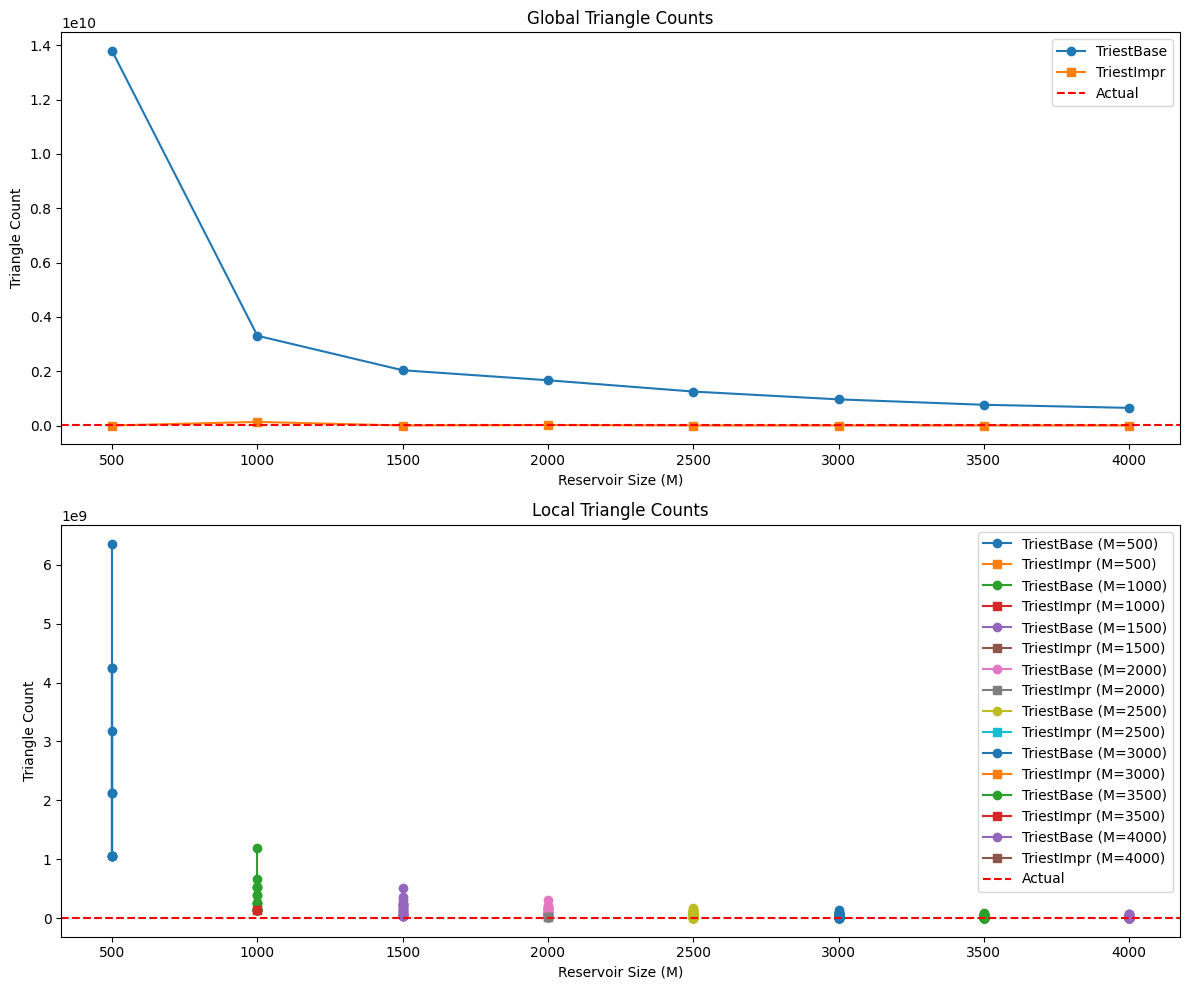

In [36]:
# Actual triangle count (from given data_set info)
actual_triangle_count = 1624481
reservoir_sizes = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
results_base = {'global': {}, 'local': {}}
results_impr = {'global': {}, 'local': {}}

for M in reservoir_sizes:
    edge_sample_base = EdgeSample()
    # Create an instance of TriestBase
    triest_base = TriestBase(M, edge_sample_base)

    # Process the edges for TriestBase
    triest_base.process_edges(edges_list)

    # Get the estimated triangle counts for TriestBase
    counters_base = triest_base.return_triangle_counts()
    results_base['global'][M] = counters_base['global']
    results_base['local'][M] = counters_base['local']

    # Create an instance of TriestImpr
    triest_impr = TriestImpr(M, 0.1)  # You may need to adjust the decay factor

    # Process the edges for TriestImpr
    triest_impr.process_edges_with_decay(edges_list)

    # Get the estimated triangle counts for TriestImpr
    counters_impr = triest_impr.return_triangle_counts()
    results_impr['global'][M] = counters_impr['global']
    results_impr['local'][M] = counters_impr['local']

# Plotting the results
plt.figure(figsize=(12, 10))

# Plot global triangle count estimates for TriestBase and TriestImpr
plt.subplot(2, 1, 1)
plt.plot(reservoir_sizes, [results_base['global'][M] for M in reservoir_sizes], marker='o', linestyle='-', label='TriestBase')
plt.plot(reservoir_sizes, [results_impr['global'][M] for M in reservoir_sizes], marker='s', linestyle='-', label='TriestImpr')
plt.axhline(y=actual_triangle_count, color='r', linestyle='--', label='Actual')
plt.title('Global Triangle Counts')
plt.xlabel('Reservoir Size (M)')
plt.ylabel('Triangle Count')
plt.legend()

# Plot local triangle count estimates for TriestBase and TriestImpr
plt.subplot(2, 1, 2)
for M in reservoir_sizes:
    plt.plot([M]*len(results_base['local'][M]), results_base['local'][M].values(), 'o', label=f'TriestBase (M={M})', linestyle='-', marker='o')
    plt.plot([M]*len(results_impr['local'][M]), results_impr['local'][M].values(), 's', label=f'TriestImpr (M={M})', linestyle='-', marker='s')

plt.axhline(y=actual_triangle_count, color='r', linestyle='--', label='Actual')
plt.title('Local Triangle Counts')
plt.xlabel('Reservoir Size (M)')
plt.ylabel('Triangle Count')
plt.legend()

plt.tight_layout()
plt.show()


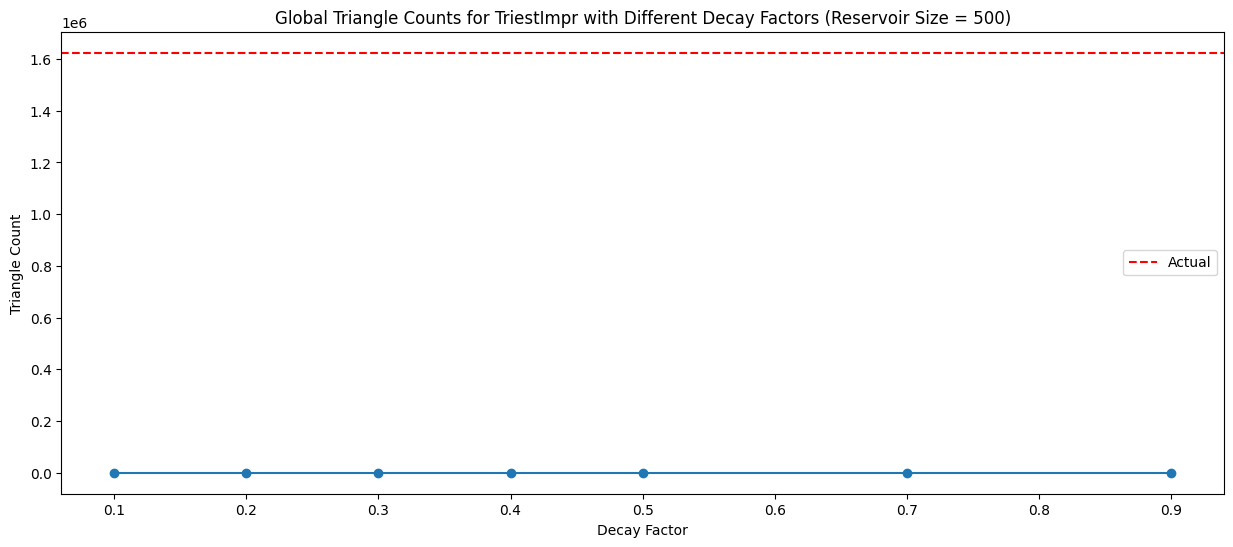

In [40]:
# Actual triangle count (from given data_set info)
actual_triangle_count = 1624481
reservoir_size = 500
decay_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]

results_impr = {'global': {}, 'local': {}}

for decay_factor in decay_factors:
    results_impr['global'][decay_factor] = {}
    results_impr['local'][decay_factor] = {}

    edge_sample_impr = EdgeSample()
    # Create an instance of TriestImpr
    triest_impr = TriestImpr(reservoir_size, decay_factor)

    # Process the edges for TriestImpr
    triest_impr.process_edges_with_decay(edges_list)

    # Get the estimated triangle counts for TriestImpr
    counters_impr = triest_impr.return_triangle_counts()
    results_impr['global'][decay_factor] = counters_impr['global']
    results_impr['local'][decay_factor] = counters_impr['local']

# Plotting the results
plt.figure(figsize=(15, 6))

# Plot global triangle count estimates for TriestImpr with different decay factors
plt.plot(decay_factors, [results_impr['global'][decay_factor] for decay_factor in decay_factors], marker='o', linestyle='-')
plt.axhline(y=actual_triangle_count, color='r', linestyle='--', label='Actual')
plt.title('Global Triangle Counts for TriestImpr with Different Decay Factors (Reservoir Size = 500)')
plt.xlabel('Decay Factor')
plt.ylabel('Triangle Count')
plt.legend()


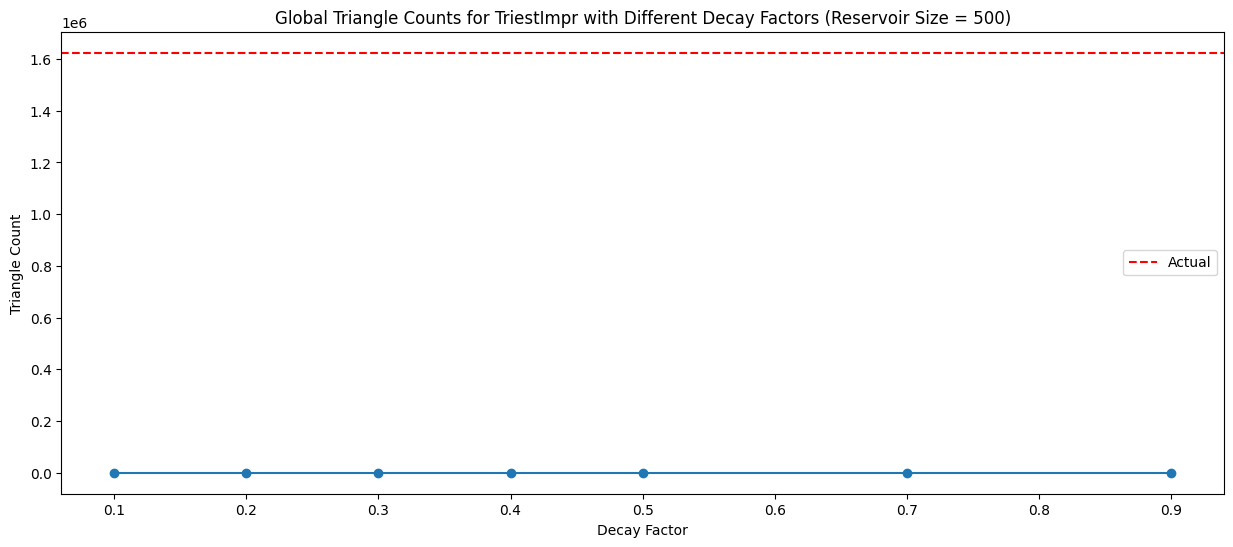

In [41]:
# Actual triangle count (from given data_set info)
actual_triangle_count = 1624481
reservoir_size = 4000
decay_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]

results_impr = {'global': {}, 'local': {}}

for decay_factor in decay_factors:
    results_impr['global'][decay_factor] = {}
    results_impr['local'][decay_factor] = {}

    edge_sample_impr = EdgeSample()
    # Create an instance of TriestImpr
    triest_impr = TriestImpr(reservoir_size, decay_factor)

    # Process the edges for TriestImpr
    triest_impr.process_edges_with_decay(edges_list)

    # Get the estimated triangle counts for TriestImpr
    counters_impr = triest_impr.return_triangle_counts()
    results_impr['global'][decay_factor] = counters_impr['global']
    results_impr['local'][decay_factor] = counters_impr['local']

# Plotting the results
plt.figure(figsize=(15, 6))

# Plot global triangle count estimates for TriestImpr with different decay factors
plt.plot(decay_factors, [results_impr['global'][decay_factor] for decay_factor in decay_factors], marker='o', linestyle='-')
plt.axhline(y=actual_triangle_count, color='r', linestyle='--', label='Actual')
plt.title('Global Triangle Counts for TriestImpr with Different Decay Factors (Reservoir Size = 500)')
plt.xlabel('Decay Factor')
plt.ylabel('Triangle Count')
plt.legend()


# The optional task questions:

**1. What were the challenges you faced when implementing the algorithm?**

  When we applied the TRIEST algorithm, we faced a challenge because it works best for graphs where connections between nodes don't have a direction, as mentioned in the paper we selected. However, we wanted it to also work for graphs where connections have a specific direction (like a directed graph). To make it compatible with both types, we had to spend sometimes to figure how we can process and store these directed connections.


**2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.**

  Running the TRIEST algorithm simultaneously on different parts of a graph (parallelization) is not straightforward because the algorithm is designed to work step by step. While dividing the graph into sections and working on them separately is possible (in a distributed manner), combining the results accurately is challenging. A feasible implementation would require significant changes to the algorithm, and synchronization mechanisms would be needed between workers due to the algorithm's reliance on global and local counters.

**3. Does the algorithm work for unbounded graph streams? Explain.**

  The TRIEST algorithm is effective in handling streams of data about growing graphs (unbounded streams). By using reservoir sampling, the algorithm maintains a constant memory footprint (M). This design ensures efficient use of available space, preventing problems such as memory underutilization or exhaustion. In simple terms, TRIEST with reservoir sampling seamlessly adapts to continuously growing streams while optimizing memory usage.

**4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.**

  The TRIEST algorithm mainly focuses on adding edges. To support edge deletions, adjustments would be needed to update the sample set and accurately estimate triangle counts when edges are removed from the streaming graph. This modification may involve tracking edge deletions and adjusting triangle counts during the update process.

  The implemented algorithms are insertion-only. However, in the paper, there is another algorithm called the Fully Dynamic algorithm, which handles both insertions and deletions based on random pairing (RP). The idea is that edge deletions will be compensated by later edge insertions in the stream. Counters are used to keep track of uncompensated edge deletions.